In [ ]:
import pandas as pd
import numpy as np
import sqlite3
from tqdm import tqdm
import pickle
from pandarallel import pandarallel
from time import time
from tokenizers import Tokenizer
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import scipy.sparse as sp
from goatools.obo_parser import GODag
from goatools.mapslim import mapslim
from goatools.gosubdag.gosubdag import GoSubDag
import requests
import os
import re
import itertools
import json

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils import resample
from collections import defaultdict
import random

from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import spearmanr, pearsonr

from bertopic import BERTopic
from bertopic.backend import BaseEmbedder
from bertopic.cluster import BaseCluster
from bertopic.vectorizers import ClassTfidfTransformer
from bertopic.dimensionality import BaseDimensionalityReduction
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.representation import KeyBERTInspired

from typing import List, Dict, Tuple, Set, Any, Optional, Union

import networkx as nx

from vocabulary_functions import load_tokenizers
from go_functions import (
    create_unit_documents, create_go_labels, create_bertopic_model, 
    create_graph_aware_bertopic_model, split_data
)

In [2]:
# Initialize pandarallel for parallel processing
pandarallel.initialize(nb_workers=20, progress_bar=True)

INFO: Pandarallel will run on 20 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [3]:
# --- GO DAG and GO Slim Setup ---
ob_url = "http://purl.obolibrary.org/obo/go/go-basic.obo"
obo_path = "go-basic.obo"
if not os.path.exists(obo_path):
    with open(obo_path, "w") as f:
        f.write(requests.get(obo_url).text)
go_dag = GODag(obo_path)

goslim_url = "http://current.geneontology.org/ontology/subsets/goslim_generic.obo"
goslim_path = "goslim_generic.obo"
if not os.path.exists(goslim_path):
    with open(goslim_path, "w") as f:
        f.write(requests.get(goslim_url).text)
goslim_dag = GODag(goslim_path)
goslim_terms = set(goslim_dag.keys())
go_subdag_slim = GoSubDag(goslim_terms, go_dag)
goslim_id2name = {go_id: go_dag[go_id].name for go_id in goslim_terms}
goslim_name2id = {go_dag[go_id].name: go_id for go_id in goslim_terms}

go-basic.obo: fmt(1.2) rel(2025-03-16) 43,544 Terms
goslim_generic.obo: fmt(1.2) rel(go/2025-03-16/subsets/goslim_generic.owl) 206 Terms
 GoSubDag: 206 sources in 335 GOs rcnt(True). 65 alt GO IDs
 GoSubDag: namedtuple fields: NS level depth GO alt GO_name dcnt D1 id
 GoSubDag: relationships: set()


In [4]:
G = nx.DiGraph()
for go_id, go_term in go_subdag_slim.go2obj.items():
    G.add_node(go_id, name=go_term.name, namespace=go_term.namespace)
    for parent in go_term.parents:
        if parent.id in go_subdag_slim.go2obj:  # Only connect if parent is also in slim
            G.add_edge(parent.id, go_id)
G.add_node('GO:0000000', name='root_node', namespace='root_node')
G.add_edge('GO:0000000', 'GO:0008150') # biological_process
G.add_edge('GO:0000000', 'GO:0005575') # cellular_component
G.add_edge('GO:0000000', 'GO:0003674') # molecular_function

In [5]:
# --- Tokenizer and Vocabulary Configuration ---
vocab_sizes = [1600, 3200, 6400, 12800, 25600]
uniref_id = "50"

tokenizer_opts_list = [
    {
        'is_mut': False,
        'dataset': f'uniref{uniref_id}',
        'is_pretokenizer': False,
        'subs_matrix': 'blosum62',
        'mutation_cutoff': 0.7,
        'min_mutation_freq': 0.05,
        'min_mutation_len': 3,
        'max_mutation_len': 12,
        'vocab_size': vocab_sizes
    },
    {
        'is_mut': True,
        'dataset': f'uniref{uniref_id}',
        'is_pretokenizer': False,
        'subs_matrix': 'blosum62',
        'mutation_cutoff': 0.7,
        'min_mutation_freq': 0.05,
        'min_mutation_len': 3,
        'max_mutation_len': 12,
        'vocab_size': vocab_sizes
    },
    {
        'is_mut': True,
        'dataset': f'uniref{uniref_id}',
        'is_pretokenizer': True,
        'subs_matrix': 'pam70',
        'mutation_cutoff': 0.7,
        'min_mutation_freq': 0.05,
        'min_mutation_len': 3,
        'max_mutation_len': 12,
        'vocab_size': vocab_sizes
    },
]

tokenizer_list = load_tokenizers(tokenizer_opts_list, 'hf')
inner_vocab_list = load_tokenizers(tokenizer_opts_list, 'vocab')

vocab_list = {name: list(set(tok.get_vocab().keys())) for name, tok in tokenizer_list.items()}
methods = [name[:-len(str(vocab_sizes[0]))-1] for name in list(tokenizer_list.keys())[::len(vocab_sizes)]]
methods2names = {mn: mn.replace('mut', 'evo').replace('std', '').replace('blosum', 'BLOSUM').replace('pam', 'PAM').replace('pre', 'Pre') for mn in methods}
methods2names = {k: ' '.join(v.split()[:-2]) if 'evoBPE' in v else v for k, v in methods2names.items()}

In [6]:
# --- Vocabulary Lineage Construction ---
vocab_lineage_list = {}
for k, v in inner_vocab_list.items():
    vocab_lineage_list[k] = {token: {
        'frequency': -1, 'order': -1, 'parent_pair': [], 'parent_mutation': "",
        'parent_mutation_similarity': -1, 'partner_pair_self': False,
        'partner_pair_left': [], 'partner_pair_right': [], 'child_pair': [], 'child_mutation': []
    } for token in v.keys()}

for method_name, vocab in tqdm(inner_vocab_list.items(), desc="Building Vocabulary Lineage"):
    for token, inner_elements in vocab.items():
        lineage = vocab_lineage_list[method_name][token]
        lineage['frequency'] = inner_elements.get('frequency', -1)
        lineage['order'] = inner_elements.get('order', -1)
        lineage['parent_pair'] = inner_elements.get('pair', [])
        lineage['parent_mutation'] = inner_elements.get('parent', "")
        lineage['parent_mutation_similarity'] = inner_elements.get('similarity', -1)

        if 'pair' in inner_elements:
            p1, p2 = inner_elements['pair']
            if p1 == p2:
                vocab_lineage_list[method_name][p1]['partner_pair_self'] = True
                vocab_lineage_list[method_name][p1]['child_pair'].append(token)
            else:
                vocab_lineage_list[method_name][p1]['partner_pair_right'].append(p2)
                vocab_lineage_list[method_name][p2]['partner_pair_left'].append(p1)
                vocab_lineage_list[method_name][p1]['child_pair'].append(token)
                vocab_lineage_list[method_name][p2]['child_pair'].append(token)
        if 'parent' in inner_elements:
            parent = inner_elements['parent']
            vocab_lineage_list[method_name][parent]['child_mutation'].append(token)

Building Vocabulary Lineage: 100%|██████████| 15/15 [00:00<00:00, 84.02it/s]


In [7]:
# --- Database Connection and Data Loading ---
db_file = "/cta/share/users/uniprot/human/human.db"
conn = sqlite3.connect(db_file)

df_protein = pd.read_sql(f"SELECT Entry as uniprot_id, Sequence as sequence FROM proteins WHERE Entry IN (SELECT uniprot_accession FROM uniref{uniref_id}_distilled)", conn)
df_protein = df_protein[df_protein['sequence'].str.len() < 3000].reset_index(drop=True)
df_protein = df_protein[df_protein['sequence'].str.len() > 100].reset_index(drop=True)

df_protein_sliced = pd.read_sql(f"SELECT uniprot_id, sequence FROM uniref{uniref_id}_domain_sliced_plddt70", conn)
df_protein_sliced = df_protein_sliced[df_protein_sliced['uniprot_id'].isin(df_protein['uniprot_id'])].reset_index(drop=True)

df_quickgo = pd.read_sql(f"SELECT uniprot_id, go_id, go_evidence FROM uniprot_quickgo_annotations", conn)
df_quickgo = df_quickgo[df_quickgo['uniprot_id'].isin(df_protein['uniprot_id'])]

# Filter by evidence code
go_evidence_experimental = ['EXP', 'IDA', 'IPI', 'IMP', 'IGI', 'IEP']
go_evidence_computational = ['ISS', 'ISO', 'ISA', 'ISM', 'RCA', 'TAS', 'IEA']
# go_evidence_computational = []
df_quickgo = df_quickgo[df_quickgo['go_evidence'].isin(go_evidence_experimental + go_evidence_computational)].reset_index(drop=True)

# Convert go_ids to go_slim_ids
df_quickgo['go_slim_id'] = df_quickgo['go_id'].apply(lambda x: list(mapslim(x, go_dag, goslim_dag)[0]) if x in go_dag else [])
df_quickgo['go_slim_id'] = df_quickgo['go_slim_id'].apply(lambda x: x[0] if len(x) > 0 else '')
df_quickgo = df_quickgo[df_quickgo['go_slim_id'] != '']

# Drop duplicates
# df_quickgo = df_quickgo.groupby(['uniprot_id', 'go_slim_id']).count().reset_index().sort_values(['uniprot_id', 'go_id'], ascending=False)
df_quickgo = df_quickgo.groupby(['uniprot_id', 'go_slim_id']).agg({'go_id': 'count', 'go_evidence': list}).reset_index().sort_values(['uniprot_id', 'go_id'], ascending=False)
df_quickgo = df_quickgo.drop(columns=['go_id']).rename(columns={'go_slim_id': 'go_id'}).reset_index(drop=True)

# Drop infrequent go terms
df_quickgo = df_quickgo[df_quickgo['go_id'].isin(df_quickgo['go_id'].value_counts()[df_quickgo['go_id'].value_counts() > 100].index)].reset_index(drop=True)

# Add GO term information
df_quickgo['go_name'] = df_quickgo['go_id'].apply(lambda go_id: go_dag[go_id].name)
df_quickgo['go_aspect'] = df_quickgo['go_id'].apply(lambda go_id: go_dag[go_id].namespace)

conn.close()

df_quickgo

,uniprot_id,go_id,go_evidence,go_name,go_aspect
0,X6RLR1,GO:0005730,[IDA],nucleolus,cellular_component
1,X6RLR1,GO:0005829,[IDA],cytosol,cellular_component
2,X6RLN4,GO:0005829,[IDA],cytosol,cellular_component
3,X6RL45,GO:0016787,[IEA],hydrolase activity,molecular_function
4,X6RK96,GO:0003723,"[IEA, IEA]",RNA binding,molecular_function
...,...,...,...,...,...
133702,A0A024QY88,GO:0048018,[IEA],receptor ligand activity,molecular_function
133703,A0A024QY88,GO:0048856,[IEA],anatomical structure development,biological_process
133704,A0A024CHX5,GO:0016787,"[IEA, IEA, IEA]",hydrolase activity,molecular_function
133705,A0A024CHX5,GO:0005576,[IEA],extracellular region,cellular_component


In [8]:
df_quickgo['go_aspect'].value_counts()

go_aspect
cellular_component    50057
biological_process    43283
molecular_function    40367
Name: count, dtype: int64

In [11]:
df_quickgo['go_name'].value_counts()

go_name
nucleus                                     8505
cytosol                                     5954
plasma membrane                             5817
nucleoplasm                                 5205
catalytic activity, acting on a protein     4823
                                            ... 
vacuole                                      119
histone binding                              114
regulatory ncRNA-mediated gene silencing     111
renal system process                         110
vitamin metabolic process                    108
Name: count, Length: 105, dtype: int64

In [10]:
# --- Tokenization and Data Merging ---
for name, tokenizer in tqdm(tokenizer_list.items(), desc="Tokenizing Sequences"):
    if 'pre' in name:
        df_protein_sliced[name] = [enc.tokens for enc in tokenizer.encode_batch(df_protein_sliced['sequence'])]
    else:
        df_protein[name] = [enc.tokens for enc in tokenizer.encode_batch(df_protein['sequence'])]

df_protein_sliced = df_protein_sliced.groupby('uniprot_id').sum().reset_index()
df_protein = df_protein.set_index(['uniprot_id', 'sequence']).join(df_protein_sliced.set_index(['uniprot_id', 'sequence'])).reset_index()
df_protein_go = pd.merge(df_quickgo, df_protein, how='inner', on='uniprot_id')
df_protein_go

Tokenizing Sequences: 100%|██████████| 15/15 [00:30<00:00,  2.07s/it]


,uniprot_id,go_id,go_evidence,go_name,go_aspect,sequence,BPE 1600,BPE 3200,BPE 6400,BPE 12800,...,PUMA blosum62 0.7 0.05 1600,PUMA blosum62 0.7 0.05 3200,PUMA blosum62 0.7 0.05 6400,PUMA blosum62 0.7 0.05 12800,PUMA blosum62 0.7 0.05 25600,PUMA pre pam70 0.7 0.05 1600,PUMA pre pam70 0.7 0.05 3200,PUMA pre pam70 0.7 0.05 6400,PUMA pre pam70 0.7 0.05 12800,PUMA pre pam70 0.7 0.05 25600
0,X6RLR1,GO:0005730,[IDA],nucleolus,cellular_component,MAGLTDLQRLQARVEELERWVYGPGGARGSRKVADGLVKVQVALGN...,"[MA, GLT, DL, QRL, QA, RV, EEL, ER, WV, YG, PG...","[MA, GLT, DL, QRL, QA, RV, EEL, ER, WV, YG, PG...","[MA, GLT, DL, QRL, QA, RV, EEL, ER, WV, YG, PG...","[MA, GLT, DL, QRL, QARV, EEL, ER, WV, YG, PGGA...",...,"[MA, GLT, DL, QRL, QA, RV, EEL, ER, WV, YG, PG...","[MA, GLT, DL, QRL, QA, RV, EEL, ER, WV, YG, PG...","[MA, GLT, DL, QRL, QA, RV, EEL, ER, WV, YG, PG...","[MA, GLT, DL, QRL, QA, RV, EEL, ER, WV, YG, PG...","[MA, GLT, DL, QRL, QARV, EEL, ER, WV, YG, PGG,...","[MA, GL, TDL, QRL, QA, RV, EEL, ER, WV, YG, PG...","[MA, GL, TDL, QRL, QA, RV, EEL, ER, WV, YG, PG...","[MA, GL, TDL, QRL, QA, RV, EEL, ER, WV, YG, PG...","[MAGL, TDL, QRL, QA, RV, EEL, ER, WV, YG, PGG,...","[MAGL, TDL, QRL, QARV, EEL, ER, WV, YG, PGG, A..."
1,X6RLR1,GO:0005829,[IDA],cytosol,cellular_component,MAGLTDLQRLQARVEELERWVYGPGGARGSRKVADGLVKVQVALGN...,"[MA, GLT, DL, QRL, QA, RV, EEL, ER, WV, YG, PG...","[MA, GLT, DL, QRL, QA, RV, EEL, ER, WV, YG, PG...","[MA, GLT, DL, QRL, QA, RV, EEL, ER, WV, YG, PG...","[MA, GLT, DL, QRL, QARV, EEL, ER, WV, YG, PGGA...",...,"[MA, GLT, DL, QRL, QA, RV, EEL, ER, WV, YG, PG...","[MA, GLT, DL, QRL, QA, RV, EEL, ER, WV, YG, PG...","[MA, GLT, DL, QRL, QA, RV, EEL, ER, WV, YG, PG...","[MA, GLT, DL, QRL, QA, RV, EEL, ER, WV, YG, PG...","[MA, GLT, DL, QRL, QARV, EEL, ER, WV, YG, PGG,...","[MA, GL, TDL, QRL, QA, RV, EEL, ER, WV, YG, PG...","[MA, GL, TDL, QRL, QA, RV, EEL, ER, WV, YG, PG...","[MA, GL, TDL, QRL, QA, RV, EEL, ER, WV, YG, PG...","[MAGL, TDL, QRL, QA, RV, EEL, ER, WV, YG, PGG,...","[MAGL, TDL, QRL, QARV, EEL, ER, WV, YG, PGG, A..."
2,X6RLN4,GO:0005829,[IDA],cytosol,cellular_component,EVKGLFKSENCPKVISCEFAHNSNWYITFQSDTDAQQAFKYLREEV...,"[EV, KGL, FK, SEN, C, PKV, I, SC, EFA, HN, SN,...","[EV, KGL, FK, SEN, C, PKV, I, SC, EFA, HN, SN,...","[EV, KGL, FK, SEN, C, PKV, I, SC, EFA, HN, SN,...","[EV, KGL, FK, SEN, C, PKV, I, SC, EFA, HN, SN,...",...,"[EV, KGL, FK, SEN, C, P, KVI, SC, E, FA, HN, S...","[EV, KGL, FK, SEN, C, P, KVI, SC, EFA, HN, SN,...","[EV, KGL, FK, SEN, C, P, KVI, SC, EFA, HN, SN,...","[EV, KGL, FK, SEN, C, PKVI, SC, EFA, HN, SN, W...","[EV, KGL, FK, SEN, C, PKVI, SC, EFA, HN, SN, W...","[EV, KGL, FK, SEN, C, P, KVI, SC, E, FA, HN, S...","[EV, KGL, FK, SEN, C, P, KVI, SC, EFA, HN, SNW...","[EV, KGL, FK, SEN, C, P, KVI, SC, EFA, HN, SNW...","[EV, KGL, FK, SEN, CP, KVI, SC, EFA, HN, SNW, ...","[EV, KGL, FK, SEN, CP, KVI, SC, EFA, HN, SNW, ..."
3,X6RL45,GO:0016787,[IEA],hydrolase activity,molecular_function,MVRCYVEIVEKLPERRPDPATIEGCAQLKPNNYLLAWHTPFNEKGS...,"[MV, RC, YV, EIV, EKL, PE, RR, PD, PA, TI, EG,...","[MV, RC, YV, EIV, EKL, PE, RR, PD, PA, TI, EG,...","[MV, RC, YV, EIV, EKL, PERR, PD, PA, TI, EG, C...","[MV, RC, YV, EIV, EKL, PERR, PDPA, TI, EG, CA,...",...,"[MV, RC, YV, EIV, EKL, PE, RR, PD, PA, TI, EG,...","[MV, RC, YV, EIV, EKL, PE, RR, PD, PA, TI, EG,...","[MV, RC, YV, EIV, EKL, PE, RR, PD, PA, TI, EG,...","[MV, RC, YV, EIV, EKL, PERR, PD, PA, TI, EG, C...","[MV, RC, YV, EIV, EKL, PERR, PD, PATI, EG, CA,...","[MV, RC, YV, EIV, EKL, PE, RR, PD, PA, TI, EG,...","[MV, RC, YV, EIV, EKL, PE, RR, PD, PA, TI, EG,...","[MV, RC, YV, EIV, EKL, PE, RR, PD, PA, TI, EG,...","[MV, RC, YV, EIV, EKL, PERR, PD, PA, TI, EG, C...","[MV, RC, YV, EIV, EKL, PERR, PDPA, TIEG, CA, Q..."
4,X6RK96,GO:0003723,"[IEA, IEA]",RNA binding,molecular_function,TSVNYLDSAFRNIRNLGIVSVTSTDISSLYAKAQHVARRHYGCNIV...,"[T, SVN, YLD, SA, FR, NI, RNL, G, IV, SVT, ST,...","[T, SVN, YLD, SA, FR, NI, RNL, G, IV, SVT, ST,...","[T, SVN, YLD, SA, FR, NI, RNL, G, IV, SVT

In [12]:
# cellular_component, molecular_function, biological_process

df = df_protein_go.copy()
df = df[df['go_aspect'] == 'molecular_function'].reset_index(drop=True).copy()

df_experimental = df[df['go_evidence'].apply(lambda x: any(e in x for e in go_evidence_experimental))].copy()

threshold = df_experimental['go_name'].value_counts()[:10].mean().astype(int)
go_counts = df_experimental['go_name'].value_counts()

underrepresented_go_names = go_counts[go_counts < threshold].index.tolist()

df_remaining = df[~df.index.isin(df_experimental.index)].copy()

supplement_rows = []

for go_name in underrepresented_go_names:
    current_count = go_counts[go_name]
    needed = threshold - current_count

    # Bu go_name'e sahip proteinlerden sadece ilk satırlarını seç (random protein seçimi)
    candidate_proteins = df_remaining[df_remaining['go_name'] == go_name]
    
    # Eğer yeterli sayıda protein yoksa, olan kadarını al
    sampled = candidate_proteins.sample(n=min(needed, len(candidate_proteins)), random_state=42)
    
    supplement_rows.append(sampled)

# 6. Tüm takviyeleri birleştir
df_supplement = pd.concat(supplement_rows)
df_balanced = pd.concat([df_experimental, df_supplement])

df_train, df_test = split_data(df_balanced, 0.2)

threshold, len(df_experimental), len(df_supplement), len(df_balanced), len(df), len(df_protein_go)

(np.int64(386), 4690, 4824, 9514, 40367, 133707)

In [13]:
df_train.shape, df_test.shape

((7609, 21), (1905, 21))

In [ ]:
tokenizer_col = 'PUMA blosum62 0.7 0.05 6400'
# tokenizer_col = 'BPE 25600'
go_col = 'go_name'
token_len_thr = 3
top_n_words = 100
lambda_smooth = 1.6
alpha = 0.5
beta = 0.6
theta = 1.2

unit_relationships = {'hierarchical': {}, 'mutational': {}}
for unit, lineage in vocab_lineage_list[tokenizer_col].items():
    if len(lineage['child_pair']) > 0:
        unit_relationships['hierarchical'][unit] = lineage['child_pair']
    if len(lineage['child_mutation']) > 0:
        unit_relationships['mutational'][unit] = lineage['child_mutation']

documents = create_unit_documents(df_train, tokenizer_col, token_len_thr)
go_labels = create_go_labels(df_train, go_col)

topic_model, _ = create_bertopic_model(documents, go_labels, token_len_thr, top_n_words)
# topic_model, _, similarity_matrix = create_graph_aware_bertopic_model(documents, go_labels, unit_relationships, token_len_thr, top_n_words, lambda_smooth, alpha, beta, theta)

2025-07-10 01:01:43,757 - BERTopic - WARNING: Note that extracting more than 100 words from a sparse can slow down computation quite a bit.


In [433]:
# --- Hypothesis Test: GO DAG Proximity vs. Protein Unit Similarity ---

# 1. Get topic information and corresponding GO terms from the trained model
topic_info = topic_model.get_topic_info()
topic_info = topic_info[topic_info.Topic != -1]  # Exclude the outlier topic
go_names = topic_info.CustomName.tolist()
go_ids = [goslim_name2id[name] for name in go_names]
topic_ids_in_model = topic_info.Topic.tolist()

In [441]:
# 2. Compute the similarity matrix for protein unit representations (c-TF-IDF vectors)

topic_vectors = topic_model.c_tf_idf_[topic_ids_in_model, :]
unit_similarity_matrix = cosine_similarity(topic_vectors)

In [ ]:
# 2.1. Compute the similarity matrix for protein unit representations (c-TF-IDF vectors)
# topic_representations = []

# vocab = topic_model.vectorizer_model.get_feature_names_out()
# word_to_idx = {word: idx for idx, word in enumerate(vocab)}

# for go_name, topic_id in zip(go_names, topic_ids_in_model):
#     # c-TF-IDF temsilini al
#     topic_words = topic_model.get_topic(topic_id)
#     representation = np.zeros(len(vocab))
#     for word, score in topic_words:
#         if word in word_to_idx:
#             representation[word_to_idx[word]] = score
    
#     topic_representations.append(representation)
# topic_representations = np.array(topic_representations)
# topic_representations = topic_representations[:, ~(topic_representations == 0).all(axis=0)]
# unit_similarity_matrix = cosine_similarity(topic_representations)

In [442]:
# 3. Compute the distance matrix based on the GO DAG
dag_distance_matrix = np.zeros((len(go_ids), len(go_ids)))
undirected_G = G.to_undirected()

for i in range(len(go_ids)):
    for j in range(i, len(go_ids)):
        source_go = go_ids[i]
        target_go = go_ids[j]
        try:
            # Ensure nodes exist in the graph before calculating path length
            if undirected_G.has_node(source_go) and undirected_G.has_node(target_go):
                dist = nx.shortest_path_length(undirected_G, source=source_go, target=target_go)
                dag_distance_matrix[i, j] = dist
                dag_distance_matrix[j, i] = dist
            else:
                dag_distance_matrix[i, j] = np.nan
                dag_distance_matrix[j, i] = np.nan
        except nx.NetworkXNoPath:
            dag_distance_matrix[i, j] = np.nan
            dag_distance_matrix[j, i] = np.nan

In [443]:
# 4. Correlate the two distance/similarity measures
# Flatten the upper triangles of the matrices to get pairwise values (excluding the diagonal)
indices = np.triu_indices_from(unit_similarity_matrix, k=1)
unit_sim_flat = unit_similarity_matrix[indices]
dag_dist_flat = dag_distance_matrix[indices]

# Filter out any pairs where the DAG distance could not be calculated
valid_indices = ~np.isnan(dag_dist_flat)
unit_sim_flat = unit_sim_flat[valid_indices]
dag_dist_flat = dag_dist_flat[valid_indices]

# Calculate Spearman correlation
correlation_spearman, p_value_spearman = spearmanr(dag_dist_flat, unit_sim_flat)

print(f"Hypothesis Test Results for tokenizer: {tokenizer_col}")
print(f"Spearman Correlation between GO DAG distance and Protein Unit similarity: {correlation_spearman:.4f}")
print(f"P-value: {p_value_spearman:.4f}")
if p_value_spearman < 0.05 and correlation_spearman < 0:
    print("The negative correlation is statistically significant, which supports the hypothesis.")
elif p_value_spearman < 0.05 and correlation_spearman >= 0:
    print("A non-negative correlation was found, which does not support the hypothesis.")
else:
    print("The result is not statistically significant.")
print()

# Calculate Pearson correlation
correlation_pearson, p_value_pearson = pearsonr(dag_dist_flat, unit_sim_flat)

print(f"Hypothesis Test Results for tokenizer: {tokenizer_col}")
print(f"Pearson Correlation between GO DAG distance and Protein Unit similarity: {correlation_pearson:.4f}")
print(f"P-value: {p_value_pearson:.4f}")
if p_value_pearson < 0.05 and correlation_pearson < 0:
    print("The negative correlation is statistically significant, which supports the hypothesis.")
elif p_value_pearson < 0.05 and correlation_pearson >= 0:
    print("A non-negative correlation was found, which does not support the hypothesis.")
else:
    print("The result is not statistically significant.")

Hypothesis Test Results for tokenizer: PUMA blosum62 0.7 0.05 6400
Spearman Correlation between GO DAG distance and Protein Unit similarity: -0.1583
P-value: 0.0060
The negative correlation is statistically significant, which supports the hypothesis.

Hypothesis Test Results for tokenizer: PUMA blosum62 0.7 0.05 6400
Pearson Correlation between GO DAG distance and Protein Unit similarity: -0.1964
P-value: 0.0006
The negative correlation is statistically significant, which supports the hypothesis.


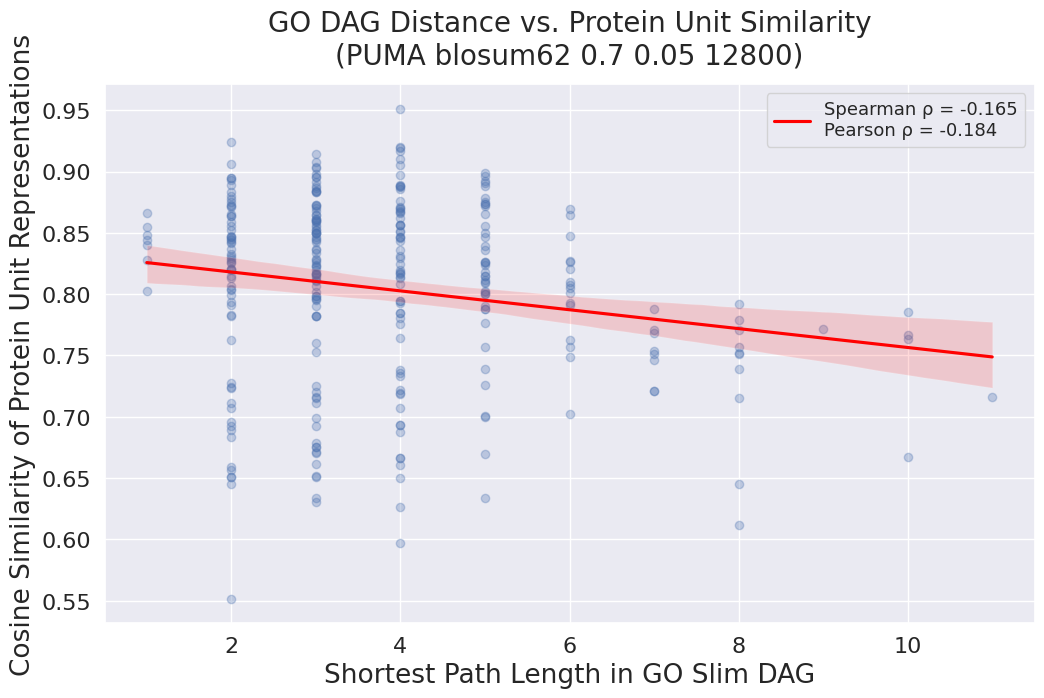

In [270]:
# 5. Visualize the relationship
tokenizer_base_name = tokenizer_col #.rsplit(' ', 1)[0]
plot_title = f'GO DAG Distance vs. Protein Unit Similarity\n({methods2names.get(tokenizer_base_name, tokenizer_base_name)})'

plt.figure(figsize=(12, 7))
sns.regplot(x=dag_dist_flat, y=unit_sim_flat, scatter_kws={'alpha':0.3}, line_kws={'color': 'red',
                                                                                   'label': f"Spearman ρ = {correlation_spearman:.3f}\nPearson ρ = {correlation_pearson:.3f}"})
plt.title(plot_title, pad=15)
plt.xlabel('Shortest Path Length in GO Slim DAG')
plt.ylabel('Cosine Similarity of Protein Unit Representations')
plt.legend()
plt.grid(True)
plt.show()

In [225]:
unit_sim_flat.mean(), unit_sim_flat.var(), dag_dist_flat.mean(), dag_dist_flat.var()

(np.float64(0.4655053733306486),
 np.float64(0.016181202755615073),
 np.float64(3.8066666666666666),
 np.float64(3.1359555555555554))

In [232]:
n_pairs = 15
n_go = len(go_names)
most_similar_pairs = [(min(x//n_go, x%n_go), max(x//n_go, x%n_go), unit_similarity_matrix[x//n_go, x%n_go]) 
                      for x in np.argsort(-unit_similarity_matrix, axis=None)[n_go:n_go+n_pairs*2:2]]

for p1, p2, sim in most_similar_pairs:
    print(f"{go_names[p1]} - {go_names[p2]}\nSimilarity: {sim:.4f}, DAG Distance: {dag_distance_matrix[p1, p2]}\n")

DNA binding - transcription regulator activity
Similarity: 0.8179, DAG Distance: 4.0

DNA binding - molecular adaptor activity
Similarity: 0.7271, DAG Distance: 4.0

molecular function regulator activity - molecular adaptor activity
Similarity: 0.7229, DAG Distance: 2.0

DNA binding - molecular function regulator activity
Similarity: 0.7110, DAG Distance: 4.0

molecular function regulator activity - cytoskeletal protein binding
Similarity: 0.7036, DAG Distance: 4.0

DNA binding - cytoskeletal protein binding
Similarity: 0.6980, DAG Distance: 4.0

molecular adaptor activity - cytoskeletal protein binding
Similarity: 0.6931, DAG Distance: 4.0

molecular function regulator activity - catalytic activity, acting on a protein
Similarity: 0.6834, DAG Distance: 3.0

transcription regulator activity - molecular adaptor activity
Similarity: 0.6776, DAG Distance: 2.0

DNA binding - catalytic activity, acting on a protein
Similarity: 0.6769, DAG Distance: 5.0

molecular function regulator activity

In [231]:
n_pairs = 15
n_go = len(go_names)
most_similar_pairs = [(min(x//n_go, x%n_go), max(x//n_go, x%n_go), dag_distance_matrix[x//n_go, x%n_go]) 
                      for x in np.argsort(dag_distance_matrix, axis=None)[n_go:n_go+n_pairs*2:2]]

for p1, p2, dag_dist in most_similar_pairs:
    print(f"{go_names[p1]} - {go_names[p2]}\nSimilarity: {unit_similarity_matrix[p1, p2]:.4f}, DAG Distance: {dag_dist}\n")

catalytic activity - lyase activity
Similarity: 0.4952, DAG Distance: 1.0

catalytic activity - ligase activity
Similarity: 0.4322, DAG Distance: 1.0

catalytic activity - catalytic activity, acting on a protein
Similarity: 0.5341, DAG Distance: 1.0

catalytic activity - transferase activity
Similarity: 0.5076, DAG Distance: 1.0

catalytic activity - ligase activity
Similarity: 0.4322, DAG Distance: 1.0

catalytic activity - hydrolase activity
Similarity: 0.5676, DAG Distance: 1.0

catalytic activity - catalytic activity, acting on a protein
Similarity: 0.5341, DAG Distance: 1.0

transcription regulator activity - structural molecule activity
Similarity: 0.5370, DAG Distance: 2.0

hydrolase activity - oxidoreductase activity
Similarity: 0.5118, DAG Distance: 2.0

molecular adaptor activity - structural molecule activity
Similarity: 0.5789, DAG Distance: 2.0

molecular adaptor activity - catalytic activity
Similarity: 0.5402, DAG Distance: 2.0

lyase activity - oxidoreductase activity
S